In [1]:
import cv2
import numpy as np
import os
import json
import pandas as pd

In [2]:
all_image_path="../HeiCuBeDa/Images_MSII_Filtered"
all_bbox_annotations_path="../MaiCuBeDa/translitmetadata.csv"
# read csv
bbox_df = pd.read_csv(all_bbox_annotations_path, sep=';',keep_default_na=False)
print(bbox_df.shape)
bbox_df.head()

(28745, 15)


,ID,Filename,CDLI_Number,IRI,Unnamed: 4,Time_period,Language,Genre,side,bbox,column,line,charindex,charname,transliteration
0,HS_1137_06,1_3(disz)_1_1_1_2_HS_1137_06_back.jpg,P134449,http://cdli.ucla.edu/P134449_back_char_1_2,https://heidicon.ub.uni-heidelberg.de/iiif/2/1...,Ur III (ca. 2100-2000 BC),Sumerian,Administrative,back,"[155, 279, 23, 111]",-1,1,2,SZUSZANA_(13),1/3(disz)
1,HS_1137_06,gin2_1_1_1_3_HS_1137_06_back.jpg,P134449,http://cdli.ucla.edu/P134449_back_char_1_3,https://heidicon.ub.uni-heidelberg.de/iiif/2/1...,Ur III (ca. 2100-2000 BC),Sumerian,Administrative,back,"[288, 474, 9, 92]",-1,1,3,MIR_(NIMGIR),gin2
2,HS_1137_06,2(disz)_1_1_1_5_HS_1137_06_back.jpg,P134449,http://cdli.ucla.edu/P134449_back_char_1_5,https://heidicon.ub.uni-heidelberg.de/iiif/2/1...,Ur III (ca. 2100-2000 BC),Sumerian,Administrative,back,"[656, 752, 0, 51]",-1,1,5,MIN_(2),2(disz)
3,HS_1100_06,igi_1_1_1_1_HS_1100_06_back.jpg,P134412,http://cdli.ucla.edu/P134412_back_char_1_1,https://heidicon.ub.uni-heidelberg.de/iiif/2/1...,Ur III (ca. 2100-2000 BC),Sumerian,Administrative,back,"[53, 165, 59, 148]",-1,1,1,IGI_(SZI__LIM),igi
4,HS_1100_06,ur_1_1_1_2_HS_1100_06_back.jpg,P134412,http://cdli.ucla.edu/P134412_back_char_1_2,https://heidicon.ub.uni-heidelberg.de/iiif/2/1...,Ur III (ca. 2100-2000 BC),Sumerian,Administrative,back,"[159, 307, 51, 126]",-1,1,2,UR,ur


In [3]:
# cut off suffixes "_..." in ID (eg. HS_1001_01_back_1 -> HS_1001_01_back)
bbox_df['tablet_ID'] = bbox_df['ID'].str.split('_').str[:-1].str.join('_')
# rename "ID" to "side_ID"
bbox_df = bbox_df.rename(columns={"ID": "side_ID"})
# save to new csv
simplified_path="../MaiCuBeDa/translitmetadata_simplified.csv"
bbox_df.to_csv(simplified_path, sep=',', index=False)

In [4]:
# count unique items on each column
print(bbox_df.nunique())
# 1070 tablets, 28224 bboxes, 478 chars, 922 transliterations

side_ID             1070
Filename           28745
CDLI_Number          592
IRI                26110
Unnamed: 4         28745
Time_period            9
Language               4
Genre                 10
side                   6
bbox               28745
column                 8
line                  30
charindex             42
charname             479
transliteration      923
tablet_ID            593
dtype: int64


In [5]:
side_text_map={
        'top':"01_top",
        'left':"02_left",
        'front':"03_front",
        'right':"04_right",
        'bottom':"05_bottom",
        'back':"06_back"
    }

In [6]:
def get_photo_path(id,side):
    side_text=side_text_map[side]
    return f"../HeiCuBeDa/Images_MSII_Filter/{id}_HeiCuBeDa_GMOCF_r1.50_n4_v512_{side_text}.png"
def get_photo(id,side):
    path=get_photo_path(id,side)
    if not os.path.exists(path):
        print(f"File not found: {path}")
        return None
    return cv2.imread(path)
# verified: all photos exist !

In [7]:
# print statistics about "side"
print(bbox_df['side'].value_counts())

side
front     16491
back      12225
bottom       14
left          6
right         6
top           3
Name: count, dtype: int64


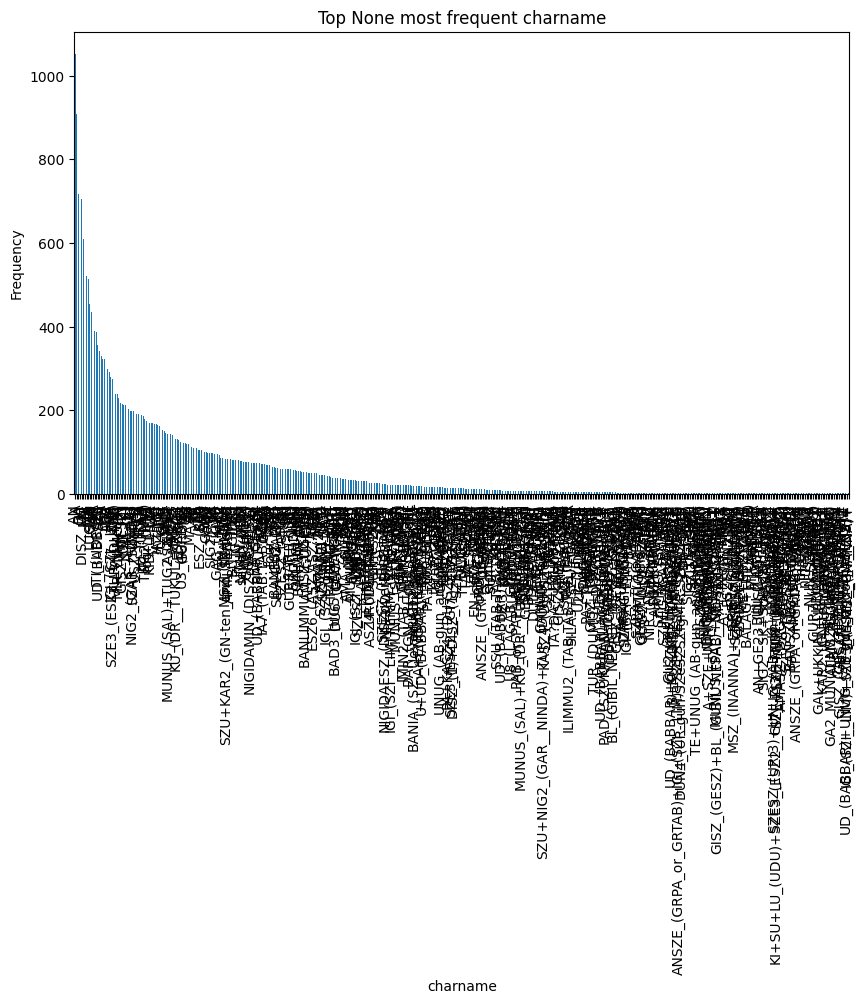

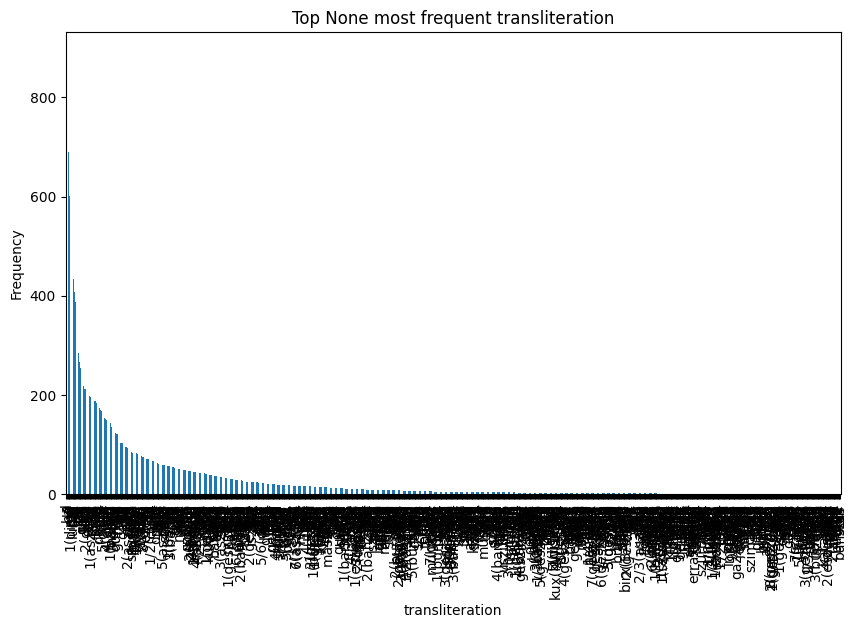

In [8]:
# plot frequency of each charname and transliteration
import matplotlib.pyplot as plt
def plot_frequency(column_name, top_n=20):
    freq = bbox_df[column_name].value_counts().head(top_n)
    plt.figure(figsize=(10, 6))
    freq.plot(kind='bar')
    plt.title(f'Top {top_n} most frequent {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()
plot_frequency('charname', top_n=None)
plot_frequency('transliteration', top_n=None)

In [9]:
# establish collection_charnames and collection_transliterations according to frequency

charname_freq = bbox_df['charname'].value_counts()
transliteration_freq = bbox_df['transliteration'].value_counts()
collection_charname = charname_freq.index.tolist()
collection_transliteration = transliteration_freq.index.tolist()

collection_charnames = {name: idx for idx, name in enumerate(collection_charname)}
collection_transliterations = {name: idx for idx, name in enumerate(collection_transliteration)}


In [10]:
def unpack_bbox_str(bbox_str):
    # input: "[xmin,xmax,ymin,ymax]"
    xmin, xmax, ymin, ymax = map(int, bbox_str.strip('[]').split(','))
    return [xmin, ymin, xmax, ymax]


def establish_photo_level_dict(df):
    photo_level_dict={}
    alloted_transliteration_id=0
    alloted_charname_id=0
    for index, row in df.iterrows():
        side_id=row['side_ID']
        tablet_id=row['tablet_ID']
        side=row['side'] # side_id = tablet_id + "_" + side
        bbox=row['bbox']
        charname=row['charname']
        transliteration=row['transliteration']
        
        
        image_path=get_photo_path(tablet_id,side)
        
        if side_id not in photo_level_dict:
            photo_level_dict[side_id]={
                'tablet_ID':tablet_id,
                'side':side,
                'image_path':image_path,
                'bboxes':[]
            }
        photo_level_dict[side_id]['bboxes'].append({
            'bbox':unpack_bbox_str(bbox),
            'charname':charname,
            'transliteration':transliteration,
            'charname_id':collection_charnames[charname],
            'transliteration_id':collection_transliterations[transliteration]
        })
    return photo_level_dict, collection_transliterations, collection_charnames
photo_level_dict, collection_transliterations, collection_charnames = establish_photo_level_dict(bbox_df)
print(f"Total photos with annotations: {len(photo_level_dict)}")
print(f"Total unique transliterations: {len(collection_transliterations)}")
print(f"Total unique charnames: {len(collection_charnames)}")


Total photos with annotations: 1070
Total unique transliterations: 923
Total unique charnames: 479


In [11]:
dict_path="../MaiCuBeDa/all_photo_anno.json"
with open(dict_path,'w') as f:
    json.dump(photo_level_dict,f, indent=4)

In [12]:
# split into train and test (80% train, 20% test)
from sklearn.model_selection import train_test_split
train_ids, test_ids = train_test_split(list(photo_level_dict.keys()), test_size=0.2, random_state=42)
print(f"Train photos: {len(train_ids)}, Test photos: {len(test_ids)}")

Train photos: 856, Test photos: 214


In [13]:
train_dict={k:photo_level_dict[k] for k in train_ids}
test_dict={k:photo_level_dict[k] for k in test_ids}
train_path="../MaiCuBeDa/train_photo_anno.json"
test_path="../MaiCuBeDa/test_photo_anno.json"
with open(train_path,'w') as f:
    json.dump(train_dict,f, indent=4)
with open(test_path,'w') as f:
    json.dump(test_dict,f, indent=4)


In [14]:
with open("../MaiCuBeDa/transliteration_to_id.json",'w') as f:
    json.dump(collection_transliterations,f, indent=4)
with open("../MaiCuBeDa/charname_to_id.json",'w') as f:
    json.dump(collection_charnames,f, indent=4)

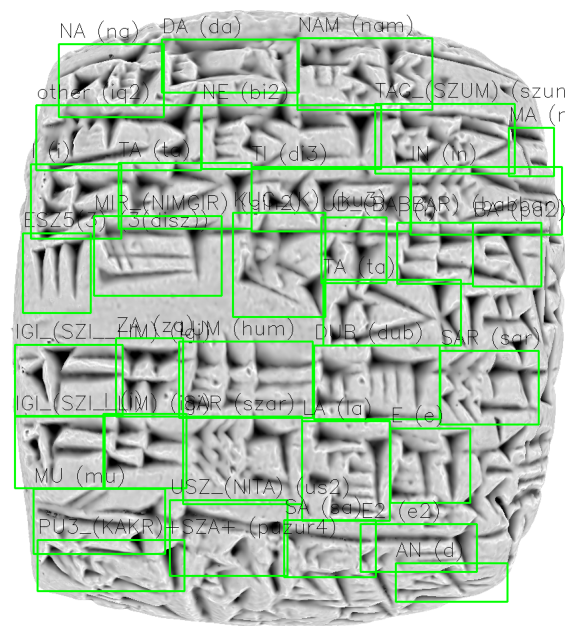

In [15]:
from visualize_photo import visualize_photo_with_bboxes
visualize_photo_with_bboxes(train_dict['HS_1007_06'])
